In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-07-05 12:48:56.164787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 12:48:56.164844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [58]:
from nltk import pos_tag
import matplotlib.pyplot as plt

In [2]:
from FairyTail.data import GetData

In [3]:
X, y = GetData().get()
len(X), len(y)

(65200, 65200)

## Let's change y to it's POS tag

In [10]:
pos_tag(["love", "big", "lovely", "loving"])

[('love', 'NN'), ('big', 'JJ'), ('lovely', 'RB'), ('loving', 'VBG')]

In [14]:
y[:4]

['the', 'from', 'a', 'movie']

In [20]:
y_tags = [x[1] for x in pos_tag(y)]

In [22]:
len(set(y_tags))

32

In [24]:
y_tags_dic = {}
for tag in y_tags:
    if tag not in y_tags_dic:
        y_tags_dic[tag] = 1
    else:
        y_tags_dic[tag] += 1
y_tags_dic

{'DT': 2867,
 'IN': 5376,
 'NN': 14284,
 'PRP': 2214,
 'WRB': 800,
 'VBZ': 2269,
 'CC': 730,
 'VBN': 1475,
 'PRP$': 1382,
 'VB': 2009,
 'VBG': 2053,
 'JJ': 8619,
 'VBD': 2127,
 'WP': 400,
 'RP': 573,
 'VBP': 2646,
 'NNS': 3019,
 'RB': 8055,
 'RBS': 118,
 'CD': 996,
 'MD': 1600,
 'TO': 200,
 'JJR': 192,
 'WDT': 244,
 'RBR': 247,
 'JJS': 550,
 'PDT': 8,
 'FW': 9,
 'EX': 134,
 'UH': 1,
 'NNP': 1,
 '$': 2}

In [29]:
df_tag = pd.DataFrame(y_tags_dic.items()).rename(columns={0 : "tag", 1 : "count"}).sort_values(by="count", ascending=False)
df_tag.head()

,tag,count
2,NN,14284
11,JJ,8619
17,RB,8055
1,IN,5376
16,NNS,3019


In [43]:
df_tag.tail(10)

,tag,count
23,WDT,244
21,TO,200
22,JJR,192
28,EX,134
18,RBS,118
27,FW,9
26,PDT,8
31,$,2
29,UH,1
30,NNP,1


In [47]:
df_tag = df_tag.head(27)

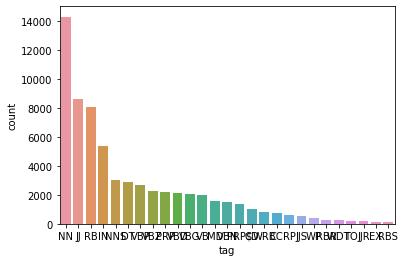

In [50]:
#plt.ylim([0,500])
sns.barplot(data=df_tag, x="tag", y="count");

In [52]:
len(y_tags)

65200

In [67]:
tags_filtered = df_tag["tag"].tolist()

In [68]:
len(tags_filtered)

27

In [80]:
y_encoded = np.zeros([len(y_tags), len(tags_filtered) + 1])
for idx, tag in enumerate(y_tags):
    if tag in tags_filtered:
        y_encoded[idx, tags_filtered.index(tag)] = 1
    else:
        y_encoded[idx, -1] = 1

In [81]:
y_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

## Let's train a model with y_tags instead of y (yes, I know, y_tags is not balanced yet)

In [83]:
# let's us a pre-trained word2vec
word2vec = api.load("glove-wiki-gigaword-50")
wv = word2vec

In [84]:
vocab_size = len(wv.key_to_index)
vocab_size

400000

In [85]:
# let's check if all words in y are in word2vec
assert(False not in [word in wv for word in y])

In [86]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3)

In [87]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed and pad the training and test sentences
X_train_pad = pad_sequences(embedding(word2vec, X_train), dtype='float32', padding='post', maxlen=20)
X_test_pad = pad_sequences(embedding(word2vec, X_test), dtype='float32', padding='post', maxlen=20)

In [88]:
# check the shape of the padded data
X_train_pad.shape, X_test_pad.shape

((45640, 20, 50), (19560, 20, 50))

In [89]:
y_train.shape

(45640, 28)

In [90]:
# build a model
def init_model():
    model = Sequential()
    model.add(Masking())
    model.add(SimpleRNN(50, activation="tanh", return_sequences=True))
    model.add(SimpleRNN(16, activation="tanh", return_sequences=False))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(28, activation="softmax"))

    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=["accuracy"])
    
    return model

model = init_model()

2022-07-05 13:58:02.699301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-05 13:58:02.699339: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 13:58:02.699368: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (think): /proc/driver/nvidia/version does not exist
2022-07-05 13:58:02.700856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [91]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad,
                    y_train, 
                    batch_size = 16,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/100


2022-07-05 13:58:38.902426: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 127788000 exceeds 10% of free system memory.


1992/1997 [============================>.] - ETA: 0s - loss: 2.6583 - accuracy: 0.2220

2022-07-05 13:58:59.134199: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 54772000 exceeds 10% of free system memory.


1997/1997 [==============================] - 23s 10ms/step - loss: 2.6577 - accuracy: 0.2221 - val_loss: 2.5569 - val_accuracy: 0.2310
Epoch 2/100
1997/1997 [==============================] - 21s 10ms/step - loss: 2.5130 - accuracy: 0.2457 - val_loss: 2.5110 - val_accuracy: 0.2433
Epoch 3/100
1997/1997 [==============================] - 21s 10ms/step - loss: 2.4625 - accuracy: 0.2568 - val_loss: 2.4761 - val_accuracy: 0.2451
Epoch 4/100
1997/1997 [==============================] - 21s 11ms/step - loss: 2.4384 - accuracy: 0.2595 - val_loss: 2.4506 - val_accuracy: 0.2506
Epoch 5/100
1997/1997 [==============================] - 21s 10ms/step - loss: 2.4229 - accuracy: 0.2643 - val_loss: 2.4494 - val_accuracy: 0.2526
Epoch 6/100
1997/1997 [==============================] - 21s 10ms/step - loss: 2.4077 - accuracy: 0.2696 - val_loss: 2.4545 - val_accuracy: 0.2518
Epoch 7/100
1997/1997 [==============================] - 21s 10ms/step - loss: 2.3957 - accuracy: 0.2717 - val_loss: 2.4382 - val_

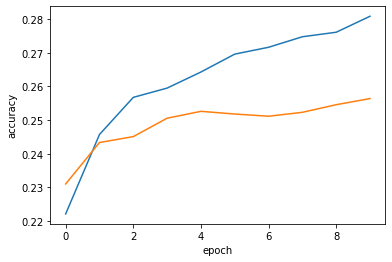

In [92]:
history_df = pd.DataFrame({
    "epoch" : history.epoch,
    "accuracy" : history.history["accuracy"],
    "val_accuracy" : history.history["val_accuracy"]
})
sns.lineplot(data=history_df, x="epoch", y="accuracy");
sns.lineplot(data=history_df, x="epoch", y="val_accuracy");